## SVM hyperparameters optimization pipeline

In this notebook I'll show one way of performing hyperparameter optimization for Support Vector Machines (with rbf kernel) models when applied to regression problems. From experience I can say that the method works relatively well (depending on the data set of course) when compared to classical grid search and random grid search methods. <br>

The method is based on the theoretical foundations of <br>
*Cherkassky, V.; Ma, Y. Practical selection of SVM parameters and noise estimation for SVM regression. 689 Neural Networks 2004, 17, 113 – 126* <br> 
<br>
and further expanded by <br>
<br>
*Kaneko, H.; Funatsu, K. Fast optimization of hyperparameters for support vector regressionmodels with 687 highly predictive ability. Chemometr. Intell. Lab. 2015, 142, 64 – 69.* [Kaneko and Funatsu (2015)](https://manuscript.elsevier.com/S0169743915000039/pdf/S0169743915000039.pdf)

Input:
    x - vector feature data
    y - vector label data
    Output:
    Optimum parameters C, gamma and epsilon.
    NOTE: Be sure to import all relevant libs before running. Also take into consideration
          that this methods optimizes the hyperparameters for scaled x in the interval [0,1].
          This is done using MinMaxScaler(). The input x values must already be in that
          interval.

Support Vector Machines for regression has been used in recent years with great success in data analysis and is considered a very versatile technique in machine learning. The efficiency of the SVM model is highly dependent of its hyper-parameters optimization, which means that in the case of using a gaussian kernel (RBF-kernel), hyper-parameters $C$, $\gamma$ and $\epsilon$ have to be optimized (for each data set individually). $C$ is the regularization parameter and it controls a tradeoff between the allowed error deviations and the complexity of the decision function, $\epsilon$ is related to the error penalty of the loss function and $\gamma$ represents the width of the RBF kernel. In what follows I implement the
the hyper-parameter optimization proposed by Kaneko and Funatsu 2015. This method uses a combination of theoretical hyper-parameter determination (from Cherkassky and Ma 2004) coupled with a ’restrained’ grid-search approach. 

In Kaneko and Funatsu 2015, the authors show that a good estimate of parameter $C$ can be obtained analytically from the statistical distribution of the calibration data and, parameter $\epsilon$ can be obtained directly from a noise estimation in the data based on the mean squared error of a k Nearest Neighbors regressor algorithm. The theoretical value of $\gamma$ is determined by maximizing the variance of kernel similarity diversity as detailed in Cherkassky and Ma 2004. However, these theoretical parameters, are not optimized for prediction because of the statistical fluctuations that can exist in different sections of the calibration/training data. Fine-tuned values can be found in by probing an interval around these theoretical values. This part of the optimization process takes two hyper-parameters (e.g. $C$ and $\gamma$) as constant (equal to their theoretical values) and optimizes the 3rd one (e.g. $\epsilon$) by Random Grid Search (RGS) and minimization of RMSE using 5k cross-validation. This is done 3 times optimizing all hyper-parameters. It seems that for this method to work reliably the input data should lie in the [0,1] range. 

##### Data set used for exemplify the SVM optimization
The data set used to exemplify the optimization method is a subset of the VIS-NIR spectra used in *Passos, D. et al, Non-Destructive Soluble Solids Content Determination for ‘Rocha’Pear Based on VIS-SWNIR Spectroscopy Under ‘Real World’ Sorting Facility Conditions, Sensors 19, 23, (2019)*, https://www.mdpi.com/1424-8220/19/23/5165. The X data are spectra (multivariate) and the Y (target variables) are Brix values (a measure of Soluble Solids Content that correlates with the sweetness of fruit).  

**If you use this code (SVM optimization function, etc) in your work I appreciate that you cite Passos, D. et al 2019. Thanks!**
##### Workflow:

- 1) Import libraries
- 2) Define some extra help functions to facilitate downstream tasks (plots, metrics, etc.)
- 3) Import the data
- 4) Some "feature engineering" on the X data and train/test split
- 5) Defining the optimization functions for the SVM hyperparameters
    - 5.1) Results of optimization 
    - 5.2) Comparison with default SVM hyperparameters

## 1) Import libraries

In [41]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from sys import stdout
import os
import sys
import scipy.io as sio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.signal import savgol_filter
from scipy.optimize import minimize_scalar
from scipy.stats import norm, uniform
from scipy import stats

from sklearn import linear_model 
from sklearn.preprocessing import StandardScaler, Binarizer, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict,cross_val_score , KFold
from sklearn.metrics import mean_squared_error, r2_score,pairwise
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_val_score, KFold , \
    cross_validate, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm

import datetime


## 2) Pre-Built Help functions
Just some helpful functions to be used downstream...

In [42]:

def R2(y_val,y_pred):
    return stats.pearsonr(np.ravel(y_val),np.ravel(y_pred))[0]**2

## Compute the Mean Prediction Error
def comp_mpe(pred, testdata):
    return np.mean(np.abs(np.ravel(pred) - np.ravel(testdata)))

## Plot scores
def plot_scores(Y_valid, Y_pred, xcord, ycord):
    score_p = R2(Y_valid, Y_pred)
    rmse_p = np.sqrt(mean_squared_error(Y_valid, Y_pred))
    sep = np.std(Y_pred[:,0]-Y_valid)

    # Print the scores on the plot
    plt.text(xcord,ycord+2, 'R$^{2}=$ %5.3f'  % score_p)
    plt.text(xcord,ycord+1, 'RMSE: %5.3f' % rmse_p)
    plt.text(xcord,ycord, 'SEP: %5.3f' % sep)
    return


## Standard Normal Variate    
def snv(input_data):
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply standard normal variate correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:]) 
    return data_snv

## function to plot predictions and make a linear fit
def plot_prediction(y_test, y_test_pred, pred_r2, pred_rmse):
    ## Plots
    # Get plot limits
    rangey = np.max(y_test) - np.min(y_test)
    rangex = np.max(y_test_pred) - np.min(y_test_pred)

    # x=y line and +- 1std upper and lower bowndaries
    xy_x=np.ravel([np.min(y_test)-0.1*rangex, np.max(y_test)+0.1*rangex])
    xy_y=np.ravel([np.min(y_test)-0.1*rangey, np.max(y_test)+0.1*rangey])
    if isinstance(x_train, pd.DataFrame):
        xy_y_up=xy_y+np.std(y_test.values)
        xy_y_down=xy_y-np.std(y_test.values)
    else:
        xy_y_up=xy_y+np.std(y_test)
        xy_y_down=xy_y-np.std(y_test)
        
    ## Plot a linear fit to predicted test data
    plt.figure(figsize=(6,6))
    z = np.polyfit(np.ravel(y_test), np.ravel(y_test_pred), 1)
    ax = plt.subplot()
    ax.plot(xy_x, xy_y, 'k--', linewidth=2, label='y=x')
    plt.fill_between(xy_x, xy_y_down, xy_y_up, alpha=0.2)
    if isinstance(y_test,pd.DataFrame):
        ax.scatter(y_test.values,y_test_pred,c='gray',s=16, marker='o', alpha=0.66)
        ax.plot(y_test.values, z[1]+z[0]*y_test, c='navy', linewidth=3,label='linear fit')
    else:
        ax.scatter(y_test,y_test_pred,c='gray',s=16, marker='o', alpha=0.66)
        ax.plot(y_test, z[1]+z[0]*y_test, c='navy', linewidth=3,label='linear fit')
    plt.xlim(xy_x)
    plt.ylim(xy_y)
    plt.ylabel('Predicted Y', fontsize=12)
    plt.xlabel('Measured Y', fontsize=12)
#     plt.title(plot_name+': PLS',fontsize=14)
    plt.legend(loc=4)
    # Print the test error metrics on the plot
    plt.text(np.min(xy_x)+0.05*rangex, np.max(xy_y)-0.1*rangey, 'R$^{2}=$ %5.2f'  % pred_r2, fontsize=13)
    plt.text(np.min(xy_x)+0.05*rangex, np.max(xy_y)-0.15*rangey, 'RMSE: %5.2f' % pred_rmse, fontsize=13)
    plt.show()    
    return 

## 3) Import Data

In [43]:
## set path for Importing data 
dir_path = os.getcwd()

## import spectra (multivariate input variables)
X = pd.read_csv(dir_path+'\\spectra_pears.csv', index_col=False,header=None)

## import wavelengths (just for completness)
lamb = pd.read_csv(dir_path+'\\lambda.txt', index_col=False,header=None)
l=lamb.values
## Remove first 75 and last 75 wavelengths to avoid the noisy parts of the spectra 
l=l[75:950]

## import brix (target variables)
Y = pd.read_csv(dir_path+'\\brix_pears.csv', index_col=False,header=None)

## 4) Feature's engineering
Compute scaled absorbance and 1st derivative to remove baselines etc (typical chemometric pre-processing). The scalling factors used here are just to transform the data range into [0,1].

In [44]:
## convert the reflectance spectra into absorbance spectra
X_abs=np.log10(1./X)/10.

## compute 1st (smoothed) derivative of the absorbance spectra, scale it and off-set it.
X_abs_1d_snv=snv(savgol_filter(X_abs,51,2,deriv=1)[:,75:950])*0.1+ 0.5

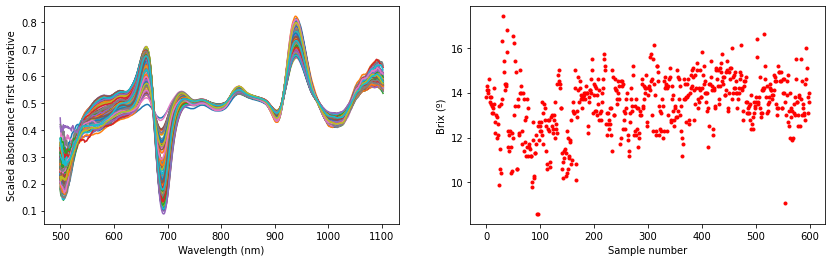

In [45]:
## Plotting some spectra just to check their shape and the brix (target variable) values.
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(l,X_abs_1d[:200,:].T)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Scaled absorbance first derivative')
plt.subplot(122)
plt.plot(Y,'r.')
plt.xlabel('Sample number')
plt.ylabel('Brix (º)')
plt.show()


We will use 500 samples for training and 100 for testing purposes.

In [46]:
x_train, x_test, y_train, y_test = train_test_split(X_abs_1d_snv, Y, test_size=100, shuffle=True, random_state=12345)

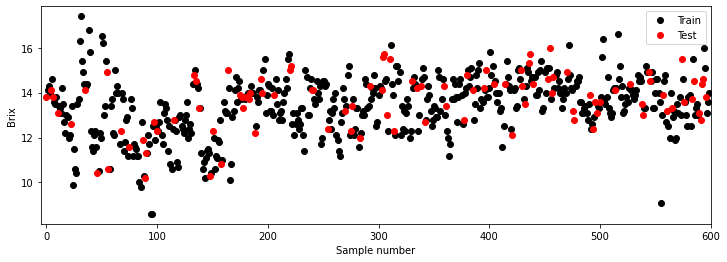

In [47]:
fig=plt.figure(figsize=(12,4))
ax1=fig.add_subplot(111)
ax1.plot(y_train,'ko',markersize=6, label='Train')
ax1.set_xlabel('Sample number')
ax1.set_ylabel('Brix')
ax1.set_xlim(-5,600)
ax1.plot(y_test,'ro',markersize=6, label='Test')
plt.legend()
plt.show()

## 5) Implementation of the SVM hyper-paremeter optimization - theoretical parameters + GridSearch

This is where we implement the functions that do the SVM (or SVR in this case) hyperparameters optimization.

In [49]:
### Transform optimization process into a function and apply it to different data-sets
def svr_param_opt2(x,y):
    """"
    SVR with rbf kernel hyperparameter optimization method based on Kaneko and Funatsu (2015)
    https://manuscript.elsevier.com/S0169743915000039/pdf/S0169743915000039.pdf
    Input:
    x - vector feature data
    y - vector label data
    Output:
    Optimal parameters C, gamma and epsilon. Also outputs the number of folds in CV (cv).
    NOTE: Be sure to import all relevant libs before running. Also take into consideration
          that this methods optimizes the hyperparameters for scaled x in the interval [0,1].
          If your data is not in this range, this cab be done using MinMaxScaler(). 
    
    By D.Passos, March 2019
    """
    
    ###### Data is rescaled to [0,1] in the subroutine that calls this one #######
    dados_x = x 
    dados_y = y
    
    
    ## Estimating the regularizer parameter C (eq.1) -----------------
    y_mean=np.mean(dados_y)
    y_std=np.std(dados_y)
    opt_C=np.max([abs(y_mean+3.*y_std) , abs(y_mean-3.*y_std)])
    print('Opt. C={}'.format(opt_C))

    ## Estimation of epsilon is equivalent to that of Cherkassky and Ma (2004),
    ## i.e. derived from the noise level based on the mean squared error of a kNN regressor 
    # number of k-neighbors
    k=3   #recomended by the authors
    
    # number of data samples
    n=len(dados_x)
    # the KNNregressor model
    knnr=KNeighborsRegressor(n_neighbors=k)
    # fit the model to the train data
    knnr.fit(dados_x,dados_y)
    # make prediction for the train data
    pred_knnr=knnr.predict(dados_x)
    ## The noise level is then give by (eq.3) of Kaneko and Funatsu 2015
    sig=np.sqrt( ((k*n**(1./5.))/(k*n**(1./5.) - 1))*np.sum((dados_y-pred_knnr)**2)/n)
    ## Cherkassky and Ma 2004 use a slightly different version
    #sig=np.sqrt((k/(k-1))*np.sum((dados_y-pred_knnr)**2)/n)
    
    ## epsilon is computed from (eq.2) ---------------------------
    opt_epsilon=3.*sig*np.sqrt(np.log(n)/n)
    print('Opt. epsilon={}'.format(opt_epsilon))

    ## We implement directly the expressions from Kaneko and Funatsu (2015)
    ## equations (4) and (5) to compute gamma. Gamma is given by maximizing
    ## variance sigma^2 in a dataset using the gaussian (RBF) kernel function
    def give_me_gamma(gamax):
        """
        Returns the variance sigma^2 as a function of the gamma parameter
        of the RBF/Gaussian kernel function.
        This function computes the Gram matrix K for the RBF kernel
        function. Afterwards it computes sigma squared sig2 from eq. (5)
        that has as free parameter the variable gamma.
        It returns -sigma squared for convinience because in the next step
        we need to find gama by minimization.
        """
        K=pairwise.rbf_kernel(dados_x,gamma=gamax)
        m_gamma=(1./n**2)*np.sum(K)               ## eq(5) of Kaneko, Funatsu 2015
        sig2=(1./n**2)*np.sum((K-m_gamma)**2)     ## eq(4) of Kaneko, Funatsu 2015
        return -sig2

    ## Find gamma that minimizes the previous function. Bounds might require tweaking!!
    res=minimize_scalar(give_me_gamma, bounds=(2e-5, 2e5), method='golden')
    ## opt_gamma is the value x that minimizes -give_me_gamma
    opt_gamma=res.x
 
    print('Opt. gamma={}'.format(opt_gamma))

    ## Define a SVR model with the found optimized parameters, fit and predict
    model_theoric=svm.SVR(kernel='rbf',C=opt_C,epsilon=opt_epsilon,gamma=opt_gamma)
      
    ## k for KFold in CV
    grupos=5
    cv = KFold(n_splits=grupos, shuffle=True, random_state=42)
    
    ## Compute more realistic error score by doing a 5 fold cross validation
    score_theoric=cross_validate(model_theoric, dados_x, dados_y, cv=cv, \
                      scoring=['neg_mean_squared_error','r2'], n_jobs=-1, \
                                 return_train_score=False, verbose=0)
    print('\nComputing final calibration RMSECV based on best theoretical hyper-paramters........................... ')
    rmsecv=np.sqrt(np.mean(-score_theoric['test_neg_mean_squared_error']))
    print('5fold CV calibration RMSE score={}'.format(rmsecv))
    print('5fold CV calibration R2 score={}'.format(np.mean(score_theoric['test_r2'])))
    
    ## returns the optimal theoretical hyper-parameters values and the CV definition for future use
    return opt_C, opt_gamma, opt_epsilon, cv
    
    

#########################  USING RANDOMIZED GRIDSEARCH VC ################################## 
def svr_param_finetune2(train_x,train_y):
    """
    This function is an extension of the previous function. Here CrossValidation (CV) and RandomizedSearchCV (RS) are used to 
    fine-tune the SVR optimal hyperparameters opt_C, opt_gamma and opt_epsilon in order to maximize the predictability. 
    This is done by looking at the error metrics of the CV. Since the expected application is regression, two metrics
    are computed (mse and R2), although the optimization relies on mse mainly.
    The details of this pipeline can be found in Kaneko and Funatsu (2015).
    NOTE: Also take into consideration that this methods optimizes the hyperparameters for 
          scaled x in the interval [0,1].This is done using MinMaxScaler(). Remember to 
          rescale you test features (x) when applying the parameters obtained with this function (in the
          case where your x is not already in the supposed interval).
    ####### input variables ##########     
    x -> vector feature data
    y -> vector label data
    #
    ####### locally computed variables ###############
    opt_C0 -> initial C (e.g. opt_C from svr_param_opt())
    opt_gamma0 -> initial gamma (e.g. opt_gamma from svr_param_opt())
    dist_C0 -> distribution of C values to test in GS
    dist_gamma0 -> distribution of gamma values to test in GS
    dist_epsilon -> distribution of epsilon values to test in GS
    ####### output variables
    opt_C -> finetuned C
    opt_gamma -> finetuned gamma
    opt_epsilon -> finetuned epsilon
    rmsecv -> RMSE of crossvalidation
    
    Usage example:
        svr_param_finetune2(x,y)
    
    By D.Passos, October 2019    
    """
    ## Rescale x data to [0,1] if needed
    ## x = MinMaxScaler().fit_transform(train_x)
    x = train_x
    y = train_y
    
    ## Compute the best theoretical hyper-parameters to initialize the GS using svr_param_opt2( )
    opt_C0, opt_gamma0, opt_epsilon0, cv = svr_param_opt2(x, y)
         
    print(opt_C0, opt_epsilon0, opt_gamma0)
    
    ## Define the distributions for hyper-paramter Random Grid Search (RGS)
    ## We use uniform distributions (from scipy.stats) to generate uniform distributions
    ## of values that range from 0.001xPARAM to 3xPARAM. This interval seems enough for 
    ## the values search but can be broaden if needed...
    dist_C       = uniform(0.001*opt_C0,3.*opt_C0)
    dist_gamma   = uniform(0.001*opt_gamma0,3*opt_gamma0)
    dist_epsilon = uniform(0.001*opt_epsilon0,3.*opt_epsilon0)
    
    ## Number of searchs to do in each distribution
    ## This has a direct impact on the time the computation takes to finish!
    num_param_search=50
    
    ## Number of folds for CV
    #  grupos=5
    #  cv = KFold(n_splits=grupos, shuffle=True, random_state=42)
    ## import cv from previous routine
    # cv=svm_model_output[3]
    
    ## Fine tune epsilon -------------------------------------
    
    ## Defining the SVM with a gaussian (rbf) kernel
    reg2=svm.SVR(kernel='rbf',cache_size=500)
    parameters = {'C':[opt_C0], 'epsilon':dist_epsilon,'gamma':[opt_gamma0]}
    
    ## We run the RGS using n_jobs=-1 for parallelization of the computation to all available CPUS. Use n_jobs=1 for just 1 CPU
    model2=RandomizedSearchCV(reg2, parameters, n_iter=num_param_search, scoring=['neg_mean_squared_error'], \
                   refit='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=1, \
                   return_train_score=False)
    print('\nFine-tunning epsilon..........................................')
    model2.fit(x,y)
    bix2 = model2.best_index_
    
    ## The score returned in the negative of mse, therefore we put a - in front to correct this.
    print('Best score={}\n'.format(np.sqrt(-model2.best_score_)),model2.best_estimator_)

    print('RMSE cv={} (+-{})'.format(np.sqrt(-model2.cv_results_['mean_test_neg_mean_squared_error'][bix2]),\
                         model2.cv_results_['std_test_neg_mean_squared_error'][bix2]))
#     print('R2 cv={} (+-{})'.format(model2.cv_results_['mean_test_r2'][0],\
#                          model2.cv_results_['std_test_r2'][0]))


    ## Fine tune C -------------------------------------
    ## get the best epsilon from previous test
    opt_epsilon=model2.best_estimator_.get_params()['epsilon']
    parameters3 = {'C':dist_C, 'epsilon':[opt_epsilon],'gamma':[opt_gamma0]}
    
    ## Do RGS
    reg3=svm.SVR(kernel='rbf',cache_size=500)
    model3=RandomizedSearchCV(reg3, parameters3, n_iter=num_param_search, scoring=['neg_mean_squared_error'], \
                   refit='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=1, \
                   return_train_score=False)
    print('\nFine-tunning C..........................................')
    model3.fit(x,y)
    bix3 = model3.best_index_
    ## The score returned in the negative of mse, therefore we put a - in front to correct this.
    print('Best score={}\n'.format(np.sqrt(-model3.best_score_)),model3.best_estimator_)
    print('RMSE cv={} (+-{})'.format(np.sqrt(-model3.cv_results_['mean_test_neg_mean_squared_error'][bix3]),\
                         model3.cv_results_['std_test_neg_mean_squared_error'][bix3]))
#     print('R2 cv={} (+-{})'.format(model3.cv_results_['mean_test_r2'][0],\
#                          model3.cv_results_['std_test_r2'][0]))


    ## Fine tune gamma -----------------------------------------
    opt_C=model3.best_estimator_.get_params()['C']

    parameters4 = {'C':[opt_C], 'epsilon':[opt_epsilon],'gamma':dist_gamma}
    reg=svm.SVR(kernel='rbf',cache_size=500)
    model4=RandomizedSearchCV(reg, parameters4, n_iter=num_param_search, scoring=['neg_mean_squared_error'], \
                   refit='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=1, \
                   return_train_score=False)
    print('\nFine-tunning gamma..........................................')
    model4.fit(x,y)
    bix4 = model4.best_index_
    ## The score returned in the negative of mse, therefore we put a - in front to correct this.
    print('Best score={}\n'.format(np.sqrt(-model4.best_score_)),model4.best_estimator_)
    print('RMSE cv={} (+-{})'.format(np.sqrt(-model4.cv_results_['mean_test_neg_mean_squared_error'][bix4]),\
                         model4.cv_results_['std_test_neg_mean_squared_error'][bix4]))
#     print('R2 cv={} (+-{})'.format(model4.cv_results_['mean_test_r2'][0],\
#                          model4.cv_results_['std_test_r2'][0]))
    
    opt_gamma=model4.best_estimator_.get_params()['gamma']
    
    print('\n\n Fine-tuned SVM hyper-paramters: \t C={} \t epsilon={} \t gamma={}'.format(opt_C,\
                                                                                         opt_epsilon,opt_gamma))
    ## Compute more realistic calibration (aka training) error score by 5 fold cross validation
    print('\nComputing final calibration RMSECV based on fine-tune hyper-paramters........................... ')
    cal_model=svm.SVR(kernel='rbf',cache_size=500,C=opt_C,epsilon=opt_epsilon,gamma=opt_gamma)
    
    cal_scores=cross_validate(cal_model, x, y, cv=cv, scoring=['neg_mean_squared_error','r2'],\
                              n_jobs=-1, return_train_score=False, verbose=0)
    rmsecv=np.sqrt(np.mean(-cal_scores['test_neg_mean_squared_error']))
    print('5fold CV calibration RMSE score={}'.format(rmsecv))
    print('5fold CV calibration R2 score={}'.format(np.mean(cal_scores['test_r2'])))
        
    return opt_C, opt_gamma, opt_epsilon, rmsecv    
    
    


def svr_predict_rmse(x_train, y_train, x_test, y_test, model_title, svmX, rmsecv):
    """
     This function outputs the RMSE for train and test sets using with a given SVM model
    -----------------------------------------------------------------------------------
     x_train = X data for train
     y_train = y data for train
     x_test = X data to test -> make prediction with
     y_test = y data to test -> compare prediction
     model_title = a string with the title or name of your model (just to print output purposes)
     svmX = the SVM model that you predifined
     rmsecv = the rmse of the cross-validation training of the SVM
    -----------------------------------------------------------------------------------
     This function uses some auxiliary function defined in the Help Functions section
     
     Dário Passos 03/07/2019
    """
    
    svr_model=svmX                             # use the imported optimal SVR model
    svr_model.fit(x_train, y_train)            # fit the SVR model
    svr_prediction=svr_model.predict(x_test)   # make prediction
    svr_prediction_cal=svr_model.predict(x_train)   # make pred. of calibration
    ## Compute RMSEP (RMSE of the test set)
    mse=mean_squared_error(y_test,svr_prediction) # compute MSE of prediction
    rmsep=np.sqrt(mse)                            # compute RMSEP
    r2p= R2(y_test,svr_prediction)                # R^2 of prediction (squared pears. corr. coef.)
    ## Comput RMSECAL (RMSE of the train test)
    rmsecal=np.sqrt(mean_squared_error(y_train,svr_prediction_cal)) # compute MSE of calibration
    
    print(model_title)
    print('\n**********************')
    print('Prediction error, RMSEP=',rmsep)
    print('Prediction R2=',r2p)
    print('\n**********************')
    ## RMSECV from calibration phase
    print('Cross validation error, RMSECV=',rmsecv)
    print('Calibration, RMSEcal=', rmsecal)
    
    ## plot the prediction
    plot_prediction(y_test, svr_prediction, r2p, rmsep)
    return rmsep, rmsecv, r2p



## function that agregates SVM hyperparameters optimization, and SVM RMSE prediction output

def svr_OP_rmse(variable_name, trainset_name, testset_name, train_X, train_y, test_X, test_y):
    """-----------------------------------------------------------------------------------
    # DP 03/07/19
    # This function optmizes the SVM model using svr_param_finetune2() and passes the optimized hyperparameters
    # of the model to the model in svr_predict_rmse that outputs the RMSE of prediction. So basically
    # this function aggregates SVM hyperparameter optimiziation and output RMSE of prediction.
    # It can be customized for calculating any other type of metrics...
    # As usual, the optimization part only relies on the training data.
    # -----------------------------------------------------------------------------------
    # variable_name = string with the name of the variable you are using for training (indicative only)
    # trainset_name = string with the name of the dataset you are using for training (indicative only)
    # testset_name = string with the name of the dataset you are using for testing (indicative only)
    # train_X =  X data set for train
    # train_y = y data for train
    # test_X = X data to test / make prediction with
    # test_y = y data to test / compare prediction
    #-----------------------------------------------------------------------------------
    """
    ## SVM hyperparamters optimization
    print('\nComputing SVM parameters (C, epsilon and gamma) for '+ variable_name + ' ----------------------\n')
    print('Optmizing SVM parameters for : '+trainset_name)
    
    ## In the following lines comment the option that does not apply to the user case
    #    
    ## Option 1: Scale the x data here: scalerx is defined using only the train data
    # xscaler = MinMaxScaler().fit(train_x)
    # scaled_train_X=scalerx.transform(train_X)
    # scaled_test_X= scalerx.transform(test_X)
    #
    ## Option 2: use this if x is already scaled in the [0,1] interval
    scaled_train_X = train_X
    scaled_test_X = test_X
    
    ## Do a GS hyper-parameter optimization around the theoretical best hyper-param. values 
    opt_C, opt_gamma, opt_epsilon, rmsecv = svr_param_finetune2(train_X, train_y)
    
    
    print('\n\n ------------------ OPTIMIZATION IS FINISHED ------------------\n\n')
    ## Use optimized SVM to make prediction on scaled y data
    svr_model=svm.SVR(C=opt_C, cache_size=500, coef0=0.0, degree=3, \
                      epsilon=opt_epsilon, gamma=opt_gamma,
                      kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

    ## Just some output string to help identify what is happening
    model_text='\nUsing optimized SVM on '+variable_name+', Fit: '+ trainset_name+' , Predict: '+testset_name
    
    ## return the error metrics for the predictions made with the optimized SVM model
    return svr_predict_rmse(scaled_train_X, train_y, scaled_test_X, test_y, model_text,svr_model,rmsecv)

### 5.1) Optimized SVM hyperparameters


Computing SVM parameters (C, epsilon and gamma) for abs_1d_snv ----------------------

Optmizing SVM parameters for : spectra 
Opt. C=17.303005120153063
Opt. epsilon=0.26787597555813275
Opt. gamma=0.8613371279498239

Computing final calibration RMSECV based on best theoretical hyper-paramters........................... 
5fold CV calibration RMSE score=0.8938911244632646
5fold CV calibration R2 score=0.5189324388766619
17.303005120153063 0.26787597555813275 0.8613371279498239

Fine-tunning epsilon..........................................
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    9.9s finished


Best score=0.8835430478695853
 SVR(C=17.303005120153063, cache_size=500, epsilon=0.4128641837513126,
    gamma=0.8613371279498239)
RMSE cv=0.8835430478695853 (+-0.13231688513186765)

Fine-tunning C..........................................
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best score=0.8771879845169195
 SVR(C=51.91931277423338, cache_size=500, epsilon=0.4128641837513126,
    gamma=0.8613371279498239)
RMSE cv=0.8771879845169195 (+-0.1536727040376663)

Fine-tunning gamma..........................................
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    9.0s finished


Best score=0.8644365751434877
 SVR(C=51.91931277423338, cache_size=500, epsilon=0.4128641837513126,
    gamma=0.4243465303267643)
RMSE cv=0.8644365751434877 (+-0.12576099471075042)


 Fine-tuned SVM hyper-paramters: 	 C=51.91931277423338 	 epsilon=0.4128641837513126 	 gamma=0.4243465303267643

Computing final calibration RMSECV based on fine-tune hyper-paramters........................... 
5fold CV calibration RMSE score=0.8644365751434877
5fold CV calibration R2 score=0.5499800334258219


 ------------------ OPTIMIZATION IS FINISHED ------------------



Using optimized SVM on abs_1d_snv, Fit: spectra  , Predict:  brix

**********************
Prediction error, RMSEP= 0.7794240996406786
Prediction R2= 0.6062937915885938

**********************
Cross validation error, RMSECV= 0.8644365751434877
Calibration, RMSEcal= 0.6925235901952507


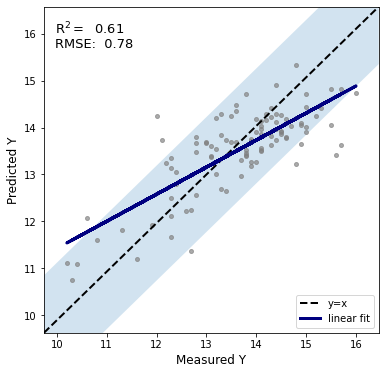

(0.7794240996406786, 0.8644365751434877, 0.6062937915885938)

In [50]:
## Note that y_train and y_test are pandas Dataframes at this points. 
## We need to pass just the values (as an array) into the svr_OP_rmse() function

## The svr_OP_rmse returns the Error metrics (in this case the Root Mean Squared Error, RMSE) 
## for the prediction (i.e. on the test set). Running this cell might take around 1 minute.

svr_OP_rmse('abs_1d_snv', 'spectra ', ' brix', x_train, np.ravel(y_train.values), \
                                            x_test, np.ravel(y_test.values))


### 5.1) Default SVM hyperparameters 

Error metrics using SVM default params

**********************
Prediction error, RMSEP= 0.9081333010999263
Prediction R2= 0.46739441483699407

**********************
Cross validation error, RMSECV= 0
Calibration, RMSEcal= 1.0257272302774545


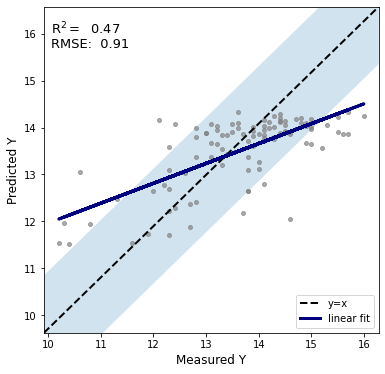

(0.9081333010999263, 0, 0.46739441483699407)

In [51]:
## Comparison with default SVM values
svr_model_default=svm.SVR(kernel='rbf')

## Compute error metrics for the predictions made with the optimized SVM model. Here we explicitly
## pass rmsecv = 0 because there was no crossvalidation calibration process.
model_text = 'Error metrics using SVM default params'
svr_predict_rmse(x_train, np.ravel(y_train), x_test, np.ravel(y_test), model_text,svr_model_default, 0)

We do see an nice improvement on the error metrics...